In [1]:
!pip install nltk

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Install necessary libraries.
!pip install tensorflow-text
!pip install --upgrade tensorflow

# import modules
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
import tensorflow as tf
import tensorflow_text as text
import string
import os

# Import necessary libraries from the correct locations.
from tensorflow.keras.preprocessing.text import Tokenizer

In [4]:

# Unzip the file and overwrite existing files without prompting.
!unzip -o /content/txt_sentoken.zip -d /tmp


# load doc
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r', encoding="utf8")  # added encoding to fix error
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc):
        tokens = doc.split()
        table = str.maketrans('', '', string.punctuation)
        tokens = [w.translate(table) for w in tokens]
        tokens = [word for word in tokens if word.isalpha()]
        stop_words = set(stopwords.words('english'))
        tokens = [w for w in tokens if not w in stop_words]
        tokens = [word for word in tokens if len(word) > 1]
        return tokens

# Use the file created by the shell commands.
filename = '/tmp/txt_sentoken/pos/cv000_29590.txt'
text = load_doc(filename)
tokens = clean_doc(text)
print(tokens)


Archive:  /content/txt_sentoken.zip
  inflating: /tmp/txt_sentoken/neg/cv000_29416.txt  
  inflating: /tmp/txt_sentoken/neg/cv001_19502.txt  
  inflating: /tmp/txt_sentoken/neg/cv002_17424.txt  
  inflating: /tmp/txt_sentoken/neg/cv003_12683.txt  
  inflating: /tmp/txt_sentoken/neg/cv004_12641.txt  
  inflating: /tmp/txt_sentoken/neg/cv005_29357.txt  
  inflating: /tmp/txt_sentoken/neg/cv006_17022.txt  
  inflating: /tmp/txt_sentoken/neg/cv007_4992.txt  
  inflating: /tmp/txt_sentoken/neg/cv008_29326.txt  
  inflating: /tmp/txt_sentoken/neg/cv009_29417.txt  
  inflating: /tmp/txt_sentoken/neg/cv010_29063.txt  
  inflating: /tmp/txt_sentoken/neg/cv011_13044.txt  
  inflating: /tmp/txt_sentoken/neg/cv012_29411.txt  
  inflating: /tmp/txt_sentoken/neg/cv013_10494.txt  
  inflating: /tmp/txt_sentoken/neg/cv014_15600.txt  
  inflating: /tmp/txt_sentoken/neg/cv015_29356.txt  
  inflating: /tmp/txt_sentoken/neg/cv016_4348.txt  
  inflating: /tmp/txt_sentoken/neg/cv017_23487.txt  
  inflating:

In [5]:
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords

# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
	# load doc
	doc = load_doc(filename)
	# clean doc
	tokens = clean_doc(doc)
	# update counts
	vocab.update(tokens)


 # load all docs in a directory
def process_docs(directory, vocab, is_trian):
	# walk through all files in the folder
	for filename in listdir(directory):
		# skip any reviews in the test set
		if is_trian and filename.startswith('cv9'):
			continue
		if not is_trian and not filename.startswith('cv9'):
			continue
		# create the full path of the file to open
		path = directory + '/' + filename
		# add doc to vocab
		add_doc_to_vocab(path, vocab)

  # define vocab
vocab = Counter()
# add all docs to vocab
process_docs('/tmp/txt_sentoken/neg', vocab, True)
process_docs('/tmp/txt_sentoken/pos', vocab, True)
# print the size of the vocab
print(len(vocab))
# print the top words in the vocab
print(vocab.most_common(50))

44276
[('film', 7983), ('one', 4946), ('movie', 4826), ('like', 3201), ('even', 2262), ('good', 2080), ('time', 2041), ('story', 1907), ('films', 1873), ('would', 1844), ('much', 1824), ('also', 1757), ('characters', 1735), ('get', 1724), ('character', 1703), ('two', 1643), ('first', 1588), ('see', 1557), ('way', 1515), ('well', 1511), ('make', 1418), ('really', 1407), ('little', 1351), ('life', 1334), ('plot', 1288), ('people', 1269), ('could', 1248), ('bad', 1248), ('scene', 1241), ('movies', 1238), ('never', 1201), ('best', 1179), ('new', 1140), ('scenes', 1135), ('man', 1131), ('many', 1130), ('doesnt', 1118), ('know', 1092), ('dont', 1086), ('hes', 1024), ('great', 1014), ('another', 992), ('action', 985), ('love', 977), ('us', 967), ('go', 952), ('director', 948), ('end', 946), ('something', 945), ('still', 936)]


In [6]:
# keep tokens with a min occurrence
min_occurane = 2
tokens = [k for k,c in vocab.items() if c >= min_occurane]
print(len(tokens))

25767


the vocabulary can be saved to a new file called vocab.txt that we can later load and use to filter movie reviews prior to encoding them for modeling. We define a new function called save_list() that saves the vocabulary to file, with one word per file.

In [7]:
# save list to file
def save_list(lines, filename):
	# convert lines to a single blob of text
	data = '\n'.join(lines)
	# open file
	file = open(filename, 'w')
	# write text
	file.write(data)
	# close file
	file.close()

# save tokens to a vocabulary file
save_list(tokens, 'vocab.txt')

Train Embedding Layer

In [8]:
# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

In [9]:
# turn a doc into clean tokens
def clean_doc(doc, vocab):
	# split into tokens by white space
	tokens = doc.split()
	# remove punctuation from each token
	table = str.maketrans('', '', punctuation)
	tokens = [w.translate(table) for w in tokens]
	# filter out tokens not in vocab
	tokens = [w for w in tokens if w in vocab]
	tokens = ' '.join(tokens)
	return tokens

In [10]:
# load all docs in a directory
def process_docs(directory, vocab, is_trian):
	documents = list()
	# walk through all files in the folder
	for filename in listdir(directory):
		# skip any reviews in the test set
		if is_trian and filename.startswith('cv9'):
			continue
		if not is_trian and not filename.startswith('cv9'):
			continue
		# create the full path of the file to open
		path = directory + '/' + filename
		# load the doc
		doc = load_doc(path)
		# clean doc
		tokens = clean_doc(doc, vocab)
		# add to list
		documents.append(tokens)
	return documents

# load all training reviews
positive_docs = process_docs('/tmp/txt_sentoken/neg', vocab, True)
negative_docs = process_docs('/tmp/txt_sentoken/pos', vocab, True)
train_docs = negative_docs + positive_docs

In [11]:
!pip install --upgrade tensorflow keras

In [12]:
# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs)

In [13]:
# sequence encode
encoded_docs = tokenizer.texts_to_sequences(train_docs)

In [14]:
import numpy as np # used for array
from tensorflow.keras.utils import pad_sequences
# pad sequences
max_length = max([len(s.split()) for s in train_docs])
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

# define training labels
ytrain = np.array([0 for _ in range(900)] + [1 for _ in range(900)])

In [19]:
# sequence encode
encoded_docs = tokenizer.texts_to_sequences(train_docs)

import numpy as np  # used for array
from tensorflow.keras.utils import pad_sequences

# pad sequences
max_length = max([len(s.split()) for s in train_docs])
X_train = pad_sequences(encoded_docs, maxlen=max_length, padding='post') # Changed Xtrain to X_train

# define training labels
y_train = np.array([0 for _ in range(900)] + [1 for _ in range(900)]) # Changed ytrain to y_train

# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1


In [20]:
# Import necessary libraries from the correct locations.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM,Conv2D, MaxPooling2D, Dropout, Dense, Input, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import nltk
import os
import numpy as np
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords

# Define the model inputs
input_layer = Input(shape=(max_length,))

# The embedding layer converts the input text to a vector representation.
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length, trainable=True)(input_layer)

# Bidirectional LSTM Layer
bi_lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)

# Reshape layer: Add a channel dimension to make it compatible with Conv2D
# max_length = height, 1 = width, 128 = channels
reshape_layer = Reshape((max_length, 1, 128))(bi_lstm_layer)

# The CNN layer extracts local features from the Bi-LSTM output.
conv_layer = Conv2D(filters=32, kernel_size=(3, 1), activation='relu')(reshape_layer) # changed kernel_size

# This layer reduces the dimensionality of the CNN output by taking the maximum value over the time dimension.
pooling_layer = MaxPooling2D(pool_size=(2,1))(conv_layer) # changed pool_size

# The dropout layer randomly sets a fraction of the input units to 0 at each update during training time, which helps prevent overfitting.
dropout_layer = Dropout(0.5)(pooling_layer)

# Add a flatten layer
flatten_layer = Flatten()(dropout_layer)

# Add a dense layer
dense_layer = Dense(128, activation='relu')(flatten_layer)

# The final output layer is a dense layer with a sigmoid activation function to predict the binary classification.
output_layer = Dense(1, activation='sigmoid')(dense_layer) # changed output_layer

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
# Create the model
model = Model(inputs=input_layer, outputs=output_layer)
# Compile the Model
# The model is compiled with an optimizer, loss function, and metrics.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.5569 - loss: 0.7071 - val_accuracy: 0.0000e+00 - val_loss: 0.8463
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.6610 - loss: 0.6110 - val_accuracy: 0.7250 - val_loss: 0.6398
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9616 - loss: 0.1082 - val_accuracy: 0.8139 - val_loss: 0.4489
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.9940 - loss: 0.0263 - val_accuracy: 0.5806 - val_loss: 2.1482
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.9987 - loss: 0.0053 - val_accuracy: 0.6000 - val_loss: 2.2038
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.7139 - val_loss: 1.7569


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# --- Model Evaluation ---
# 1. Prediction on the Validation Set
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# 2. Calculate Evaluation Metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# 3. Generate Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 508ms/step
Accuracy: 0.9611111111111111
Precision: 1.0
Recall: 0.9213483146067416
F1-Score: 0.9590643274853801


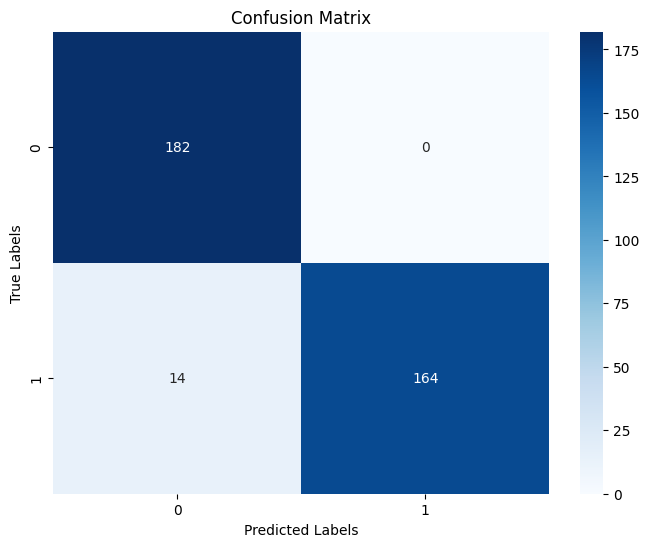

In [25]:
# 4. Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

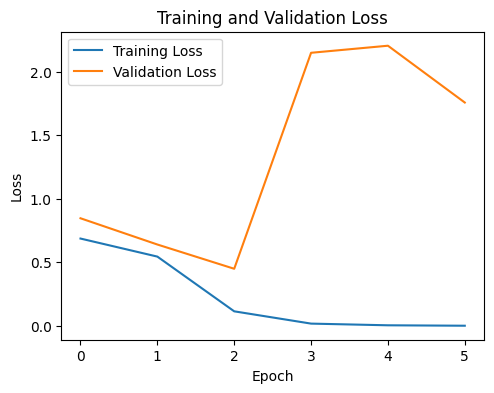

In [26]:
# 5. Plot Loss Curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()